![simona.png](https://raw.githubusercontent.com/Dreamlone/ITMO_Masters_degree/master/Images/simona.png)

## Основная идея

Клеточный автомат - дискретная модель, которая позволяет моделировать различные сложные системы с помощью перечня простых правил. Данные правила могут задаваться экспертом, или же определяться с помощью вспомогательных алгоритмов. 

В данном ноутбуке приведена идея использования решающих деревьев для инициализации правил, по которым может функционировать основная модель. Алгоритм принимает на вход некоторое количество матриц, на основе которых может строить правила и матрицу-отклик. В простейшем случае реашающее дерево применяется для задачи бинарной классификации.

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import random
import scipy
from scipy.signal import convolve2d
from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeClassifier

Представим, что нам необходимо реализовать модель, которая бы позволяла бы имитировать поведение некоторого пространственного явления. Для простоты опишем рассматриваемое явление как объект бинарной природы, например наличие или отсутствие морского льда на акватории. Лед либо занимает данную акваторию, либо нет. Обозначим присутствие морскго льда значением "1", его отсутствие в данной ячейке - "0".

Пространственное распределение поля льда в момент времени 1 опишем с помощью матрицы A1. Распределение льда в следующий момент времени 2 опишем матрицей A2.

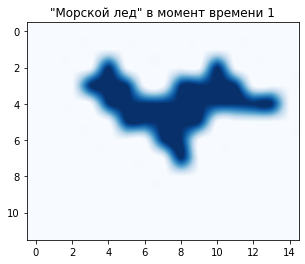

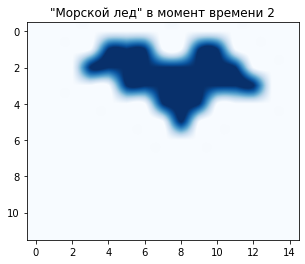

In [129]:
# Пространственное распределение параметра на шаге 1
A1 = np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,1,0,0,0,0,0,1,0,0,0,0],
               [0,0,0,1,1,1,0,0,1,1,1,1,0,0,0],
               [0,0,0,0,1,1,1,1,1,1,1,1,1,1,0],
               [0,0,0,0,0,1,1,1,1,1,0,0,0,0,0],
               [0,0,0,0,0,0,0,1,1,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0], 
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])

# Пространственное распределение параметра на шаге номер 2
A2 = np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,1,1,1,0,0,1,1,0,0,0,0],
               [0,0,0,1,1,1,1,1,1,1,1,1,0,0,0],
               [0,0,0,0,0,1,1,1,1,1,1,1,1,0,0],
               [0,0,0,0,0,0,0,1,1,1,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])

plt.imshow(A1, cmap = 'Blues', interpolation = 'spline16')
plt.title('"Морской лед" в момент времени 1')
plt.show()

plt.imshow(A2, cmap = 'Blues', interpolation = 'spline16')
plt.title('"Морской лед" в момент времени 2')
plt.show()

Помимо полей с морским льдом у нас будет присутствовать дополнительная информация в виде матриц с распределением температуры воды. Обозначим матрицу в момент времени 1 как B1.

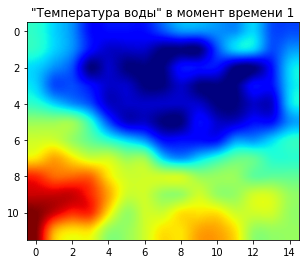

In [130]:
# Поле вспомогательного параметра
B1 = np.array([[ 6, 5, 4, 2, 2, 2, 2, 3, 4, 4, 4, 4, 5, 3, 3],
               [ 6, 5, 4, 2, 1, 1, 1, 0, 0, 0, 3, 5, 5, 3, 4],
               [ 5, 4, 3, 0, 1, 0, 0, 0, 2, 2, 2, 0, 0, 2, 5],
               [ 5, 3, 3, 2, 1, 1, 0, 0, 1, 0, 0, 0, 2, 2, 5],
               [ 6, 5, 4, 3, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 5],
               [ 8, 8, 8, 6, 3, 1, 1, 0, 0, 2, 1, 1, 2, 2, 4],
               [ 9, 9, 8, 7, 6, 5, 4, 2, 2, 2, 2, 4, 4, 5, 6],
               [10,11,10, 9, 9, 8, 8, 5, 4, 5, 6, 7, 7, 6, 6], 
               [13,12,12,12,10, 9, 9, 9, 9, 8, 8, 8, 7, 7, 7],
               [14,14,14,13,11, 9, 9, 8, 8, 9, 8, 8, 9, 9, 8],
               [15,14,13,13,10, 8, 9, 9,10,10,10, 9, 9, 9, 8],
               [15,11,10,10, 8, 8, 9,10,10,11,11,10, 8, 8, 8]])

plt.imshow(B1, cmap = 'jet', interpolation = 'spline16')
plt.title('"Температура воды" в момент времени 1')
plt.show()

## Задача - с помощью известных значений параметров в момент времени i попытаться спрогнозировать значение ячейки в момент времени i+1.

Для этого разобъем весь процессинг на 2 блока:

### 1. Определение правил функционирования клеточного автомата 

In [131]:
# Функция составления обучающего датасета для выбранной матрицы
# grid        --- исходная матрица со значениями параметра
# kernel_type --- какое ядре свертки требуется применить для данной сетки ('count', 'average')
# output      --- требуется ли подготовить всего один столбец на основе модифицированного слоя или требуется добавть исходный
# ('source', 'modified', 'both')
def prepare_train(grid, kernel_type = 'count', output = 'modified'):
    
    # Если требуется вернуть только исходный слой, то так и делаем
    if output == 'source':
        return(np.ravel(grid))
    else:
        # Выбор ядра свертки в зависимости от указанного
        if kernel_type == 'count':
            kernel = np.array([[1, 1, 1],
                               [1, 0, 1],
                               [1, 1, 1]])
        elif kernel_type == 'average':
            kernel = np.array([[1/9, 1/9, 1/9],
                               [1/9, 1/9, 1/9],
                               [1/9, 1/9, 1/9]])

        # Применение свертки
        result = convolve2d(grid, kernel, mode="same", boundary="fill")
        result = np.ravel(result)    
        
        if output == 'modified':
            return(result)
        elif output == 'both':
            return(np.ravel(grid), result)    

Формируем датафрейм с предикторами и откликом.

In [132]:
# Теперь подготовим обучающую выборку
# Сколько соседних ячеек (по окрестности Мура) в данный момент являются льдом
neighbs = prepare_train(A1, kernel_type = 'count', output = 'modified')
# Является ли пискель сам льдом в данный момент или нет
state1 = prepare_train(A1, output = 'source')
# Средняя температура в окрестности данной ячейки
tmp = prepare_train(B1, kernel_type = 'average', output = 'modified')

# Отклик в следующий момент времени
state2 = prepare_train(A2, output = 'source')

dataframe = pd.DataFrame({'state1': state1,
                          'tmp': tmp,
                          'neighbs': neighbs,
                          'state2': state2})

dataframe.head(2)

,state1,tmp,neighbs,state2
0,0,2.444444,0,0
1,0,3.333333,0,0


Обучаем модель на сформированном датасете.

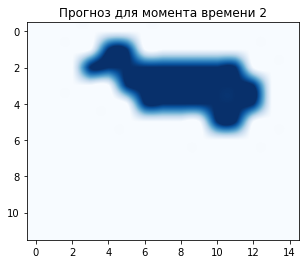

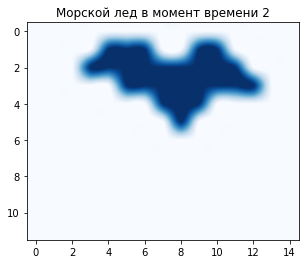

In [208]:
# Решаем задачу бинарной классификации
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state = 0, max_depth = 4)
clf.fit(dataframe[['state1', 'tmp', 'neighbs']], dataframe['state2'])

# Посмотрим на качество построенной модели
prediction = clf.predict(dataframe[['state1', 'tmp', 'neighbs']])
prediction = prediction.reshape(A2.shape[0], A2.shape[1])

plt.imshow(prediction, cmap = 'Blues', interpolation = 'spline16')
plt.title('Прогноз для момента времени 2')
plt.show()

plt.imshow(A2, cmap = 'Blues', interpolation = 'spline16')
plt.title('Морской лед в момент времени 2')
plt.show()

In [209]:
from sklearn.tree.export import export_text

tree_rules = export_text(clf, feature_names=['state1', 'tmp', 'neighbs'])
print(tree_rules)
tree_rules.split('\n')

|--- tmp <= 1.06
|   |--- neighbs <= 0.50
|   |   |--- class: 0
|   |--- neighbs >  0.50
|   |   |--- state1 <= 0.50
|   |   |   |--- class: 1
|   |   |--- state1 >  0.50
|   |   |   |--- tmp <= 0.83
|   |   |   |   |--- class: 1
|   |   |   |--- tmp >  0.83
|   |   |   |   |--- class: 1
|--- tmp >  1.06
|   |--- tmp <= 1.94
|   |   |--- neighbs <= 0.50
|   |   |   |--- class: 0
|   |   |--- neighbs >  0.50
|   |   |   |--- neighbs <= 4.50
|   |   |   |   |--- class: 1
|   |   |   |--- neighbs >  4.50
|   |   |   |   |--- class: 0
|   |--- tmp >  1.94
|   |   |--- tmp <= 2.72
|   |   |   |--- tmp <= 2.61
|   |   |   |   |--- class: 0
|   |   |   |--- tmp >  2.61
|   |   |   |   |--- class: 0
|   |   |--- tmp >  2.72
|   |   |   |--- class: 0



['|--- tmp <= 1.06',
 '|   |--- neighbs <= 0.50',
 '|   |   |--- class: 0',
 '|   |--- neighbs >  0.50',
 '|   |   |--- state1 <= 0.50',
 '|   |   |   |--- class: 1',
 '|   |   |--- state1 >  0.50',
 '|   |   |   |--- tmp <= 0.83',
 '|   |   |   |   |--- class: 1',
 '|   |   |   |--- tmp >  0.83',
 '|   |   |   |   |--- class: 1',
 '|--- tmp >  1.06',
 '|   |--- tmp <= 1.94',
 '|   |   |--- neighbs <= 0.50',
 '|   |   |   |--- class: 0',
 '|   |   |--- neighbs >  0.50',
 '|   |   |   |--- neighbs <= 4.50',
 '|   |   |   |   |--- class: 1',
 '|   |   |   |--- neighbs >  4.50',
 '|   |   |   |   |--- class: 0',
 '|   |--- tmp >  1.94',
 '|   |   |--- tmp <= 2.72',
 '|   |   |   |--- tmp <= 2.61',
 '|   |   |   |   |--- class: 0',
 '|   |   |   |--- tmp >  2.61',
 '|   |   |   |   |--- class: 0',
 '|   |   |--- tmp >  2.72',
 '|   |   |   |--- class: 0',
 '']

In [210]:
# Функция для разделения правил
def parse_rules(rules):
    # Разбиваем строки
    rules = rules.split('\n')
    
    # Цикл формирования списка из правил, которые алгоритм выделил в ходе обучения
    adj_rules = []
    for rule in rules:
        rule = rule.split('|')
        rule = rule[-1]
        node = rule.split('--- ')
        node = node[-1]
        
        if node[:6] == 'class:':
            pass
        elif node == '':
            pass
        else:
            adj_rules.append(node)
    return(adj_rules)

parse_rules(tree_rules)

['tmp <= 1.06',
 'neighbs <= 0.50',
 'neighbs >  0.50',
 'state1 <= 0.50',
 'state1 >  0.50',
 'tmp <= 0.83',
 'tmp >  0.83',
 'tmp >  1.06',
 'tmp <= 1.94',
 'neighbs <= 0.50',
 'neighbs >  0.50',
 'neighbs <= 4.50',
 'neighbs >  4.50',
 'tmp >  1.94',
 'tmp <= 2.72',
 'tmp <= 2.61',
 'tmp >  2.61',
 'tmp >  2.72']

### 2. Имитация поведения системы на основе выделенных правил